In [1]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import scipy as scp
from scipy import sparse

NUM_SAMPLES = 200
SMALL_VAL = -100000000
ITER_THRESH = 5


In [2]:
#A function to get the 20 newsgroup data
def get_data():
    #news_groups_all = fetch_20newsgroups(subset='all')
    #news_data = news_groups_all.data

    #Load in the vectorized news group data from scikit-learn package
    news = fetch_20newsgroups(subset='all')
    all_data = np.array(news.data)
    all_targets = np.array(news.target)
    class_names = news.target_names

    #Set class pairings as described in the multiview clustering paper
    view1_classes = ['comp.graphics','rec.motorcycles', 'sci.space', 'rec.sport.hockey', 'comp.sys.ibm.pc.hardware']
    view2_classes = ['rec.autos', 'sci.med','misc.forsale', 'soc.religion.christian','comp.os.ms-windows.misc']
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 200 items from each of the selected classes in view1
    for ind in range(len(view1_classes)):
        class_num = class_names.index(view1_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
   
        
    #Randomly sample 200 items from each of the selected classes in view2
    for ind in range(len(view2_classes)):
        class_num = class_names.index(view2_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)
    
    #Vectorize the data
    vectorizer = CountVectorizer()
    view1_data = vectorizer.fit_transform(view1_data)
    view2_data = vectorizer.fit_transform(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(view1_classes))
    view1_data = sparse.vstack(view1_data)
    view2_data = sparse.vstack(view2_data)
    view1_data = np.array(view1_data[shuffled_inds].todense())
    view2_data = np.array(view2_data[shuffled_inds].todense())
    labels = labels[shuffled_inds]

    return view1_data, view2_data, labels

    
    

In [3]:
v1_data, v2_data, labels = get_data()

In [4]:
def log_sum_exp(log_likes):
    a_vals =  np.max(log_likes, axis = 0)
    likes = np.exp(log_likes - a_vals)
    log_sum = a_vals + np.log(np.sum(likes, axis = 0))
    return log_sum
    
def compute_posterior(data, w_probs, alphas, k):
    log_likes = list()
    for ind in range(k):
        #Compute the likelihood
        log_like = np.sum(data * np.log(w_probs[ind]), axis = 1)
        log_likes.append(log_like)  
    log_likes = np.vstack(log_likes)
    log_prior = np.log(np.ones((k,))/ k).reshape(-1,1)
    numer = log_prior + log_likes
    denoms = log_sum_exp(numer)
    log_post = numer - denoms
    
    #Compute the denominator of posterior
    posterior = np.exp(log_post)
    log_likes = np.sum(denoms)
    
    return posterior, log_likes

def iterate(data, posteriors, k, lamB):
    
    #For each of the mixture components, compute model params
    w_probs = list()
    for ind in range(k):
        numer = data * posteriors[ind].reshape((-1, 1))
        numer = lamB - 1 + np.sum(numer, axis=0)
        denom = np.sum(numer)
        if(denom == 0):
            denom = 1
        probs = numer/denom
        w_probs.append(probs)
    w_probs = np.vstack(w_probs)
    alphas = np.mean(posteriors, axis=1)
    
    #Compute new posterior
    new_posteriors, log_like = compute_posterior(data, w_probs, alphas, k)
    return w_probs, alphas, new_posteriors, log_like

def final_clusters(posteriors):
    f_clusters = np.argmax(posteriors, axis = 0)
    return f_clusters

def compute_entropy(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        if(labs.shape[0] == 0):
            continue
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy
    

In [5]:
# Initialize the mixture model parameters 
def initialize_posterior(num_samples, k):
    posterior = np.random.dirichlet([1] * num_samples, k)
    return posterior
    

In [6]:
#The main multinomial clustering algorithm
def multinomial(v_data, labels, k = 5, lamA = 1.2, lamB=2):
    
    #Initialize cluster centers, partitions, and loop params
    v_data = np.concatenate(v_data, axis = 1)
    posterior = initialize_posterior(v_data.shape[0], k)
    f_clusters = np.argmax(posterior, axis = 0)
    objective = SMALL_VAL
    iter_stall = 0
    iter_num = 0
    entropy = 0
    
    while(iter_stall < ITER_THRESH):
        iter_num += 1
        view = (iter_num + 1) % 2
        
        #Switch partitions, Maximization, and Expectation
        w_probs, alphas, posterior, log_like = iterate(v_data, posterior, k, lamB)
        iter_stall += 1
        #Recompute objective function
        if(log_like > objective):
            objective = log_like
            iter_stall = 0
        
        #Obtain evaluation metrics
        f_clusters = np.argmax(posterior, axis = 0)
        entropy = compute_entropy(f_clusters, labels, k, 5)

    return entropy
        

In [7]:
def getSingleEntropies(v1_data, v2_data, labels):
    
    entropies = list()
    for num in range(1, 11):
        ent = multinomial([v1_data, v2_data], labels, num)
        entropies.append(ent)
        print(ent)
    return entropies

In [8]:
#Singleview multinomial
num_trials = 2
entropies_single = list()
for ind in range(num_trials):
    entropies = getSingleEntropies(v1_data, v2_data, labels)
    entropies_single.append(entropies)
entropies_single = np.array(entropies_single)
entropies_single = np.mean(entropies_single, axis=0)

2.321928094887362
2.2305533603195333
2.3051594438802496
2.2115988364628176
2.1722125012976004
2.09907905528662
2.17157206172942
2.152253808340337
2.093567682634141
2.253514248166621
2.321928094887362
2.124532060548855
2.235786576829973
2.2250455571928094
2.2255661357193386
2.118396028656077
2.1956954143218628
2.201826079486687
2.1410941206640293
2.146090549600451


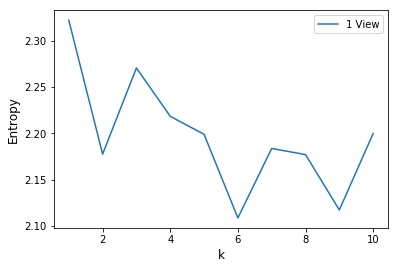

In [10]:
import matplotlib.pyplot as plt
x_values = list(range(1, 11))
plt.plot(x_values, entropies_single)
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['1 View'])
plt.rc('axes', labelsize=12)
plt.show()